# predictive modeling

In [1]:
from datetime import datetime; print("START:", datetime.now())
import socket; print("Simons Foundation, Rusty HPC,", socket.gethostname())

START: 2022-03-23 10:09:14.201018
Simons Foundation, Rusty HPC, worker3100


In [2]:
%cd ..
%load_ext rpy2.ipython

/mnt/ceph/users/zzhang/CHARM-AlternativeSplicing


## 1. Read in data

In [3]:
# import everything we will need from jemm
from jemm.junction import JunctionCountTable
from jemm.transcript import TranscriptMeasureTable
from jemm.model import Jemm, JemmLinearRegression
from jemm.plots import facet_boxplot, beta_barplot
from jemm.covariate import Contrasts, Covariate

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import average_precision_score, roc_auc_score

import pickle
import numpy as np
import pandas as pd
import os
import random

from jemm.meta_loader import MetaLoader
from jemm.covariate import Contrasts, Covariate

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use(['science', 'no-latex', 'ieee'])
import scipy

DATA_VER = 'data-V7'
PCS_TO_INCL = '0,6'
USE_RE = True

CLFDIR = '%s/das_classifier' % DATA_VER
os.makedirs(CLFDIR, exist_ok=True)
import warnings
warnings.filterwarnings("ignore")

%run ./notebook/navy_utils.V7.py $DATA_VER $PCS_TO_INCL $USE_RE

Cannot find mygene package, GeneSet functionality will be limited; you can install it by `pip install mygene`
navy_utils.py data-V7 ['PC0', 'PC6'] True


In [4]:
data_files = {
    'SE': {
        'jct': './%s/compiled/jct_SE.txt' % DATA_VER,
        'txr': './%s/compiled/txr_SE.txt'% DATA_VER
    }, 
    'A5SS': {
        'jct': './%s/compiled/jct_A5SS.pkl'% DATA_VER,
        'txr': './%s/compiled/txr_A5SS.pkl'% DATA_VER
    }, 
    'A3SS': {
        'jct': './%s/compiled/jct_A3SS.pkl'% DATA_VER,
        'txr': './%s/compiled/txr_A3SS.pkl'% DATA_VER
    }, 
    'RI': {
        'jct': './%s/compiled/jct_RI.pkl'% DATA_VER,
        'txr': './%s/compiled/txr_RI.pkl'% DATA_VER
    }
}

reg_tables = {
    'SE': './%s/joint_SE/joint.SE.reg_table.tsv'% DATA_VER,
    'A5SS': './%s/joint_A5SS/joint.A5SS.reg_table.tsv'% DATA_VER,
    'A3SS': './%s/joint_A3SS/joint.A3SS.reg_table.tsv'% DATA_VER,
    'RI': './%s/joint_RI/joint.RI.reg_table.tsv'% DATA_VER
}


contrast_cols = ['final@Pre', 'final@First', 'final@Mid', 'final@Post', 
                 'final@False Negative','final@Immune', 'final@Reinfection',
                 'final@Asymptomatic', 
                 'final@Exposed', 
                 'final@Mild',
                 'final@Moderate']

metaloader = MetaLoader(covs, data_files, reg_tables,
                        jem_type='lmm' if USE_RE else 'lm',
                        jem_kwargs={'diff_intercept_by_measure':True,
                            'group_varname': 'pid'})

loading SE..
loaded n=(81341, 1444) jct, n=(47847, 1444) txr
loading A5SS..
loaded n=(5126, 1444) jct, n=(17687, 1444) txr
loading A3SS..
loaded n=(7557, 1444) jct, n=(19353, 1444) txr
loading RI..
loaded n=(5341, 1444) jct, n=(7345, 1444) txr


In [5]:
lm_reg_tables = {
    'SE': './%s/backup_LM/joint_SE/joint.SE.reg_table.tsv'% DATA_VER,
    'A5SS': './%s/backup_LM/joint_A5SS/joint.A5SS.reg_table.tsv'% DATA_VER,
    'A3SS': './%s/backup_LM/joint_A3SS/joint.A3SS.reg_table.tsv'% DATA_VER,
    'RI': './%s/backup_LM/joint_RI/joint.RI.reg_table.tsv'% DATA_VER
}

lm_covs = Covariate(fp="./%s/charm_master.clean_w_10pc.csv" % DATA_VER, sep=",", 
                 index_col=0,
                 contrasts=contrasts,
                 main_effects= ['final', 'Sex'] + PCS_TO_INCL,
                 factor_conversion={
                     'final': {
                         'Asymptomatic': 'final@Asymptomatic',
                         'Exposed': 'final@Exposed',
                         'False Negative': 'final@False Negative',
                         'First': 'final@First',
                         'Immune': 'final@Immune',
                         'Mid': 'final@Mid',
                         'Mild': 'final@Mild',
                         'Moderate': 'final@Moderate',
                         'Post': 'final@Post',
                         'Pre': 'final@Pre',
                         'Reinfection': 'final@Reinfection'
                     },
                     'Sex': {'M': 'Sex@M'}
                 },  
                 verbose=True
             )


metaloader_lm = MetaLoader(
    lm_covs, 
    metaloader._count_tables,
    lm_reg_tables,
    jem_type='lm',
    jem_kwargs={'diff_intercept_by_measure':True}
)

loading SE..
loaded n=(81341, 1444) jct, n=(47847, 1444) txr
loading A5SS..
loaded n=(5126, 1444) jct, n=(17687, 1444) txr
loading A3SS..
loaded n=(7557, 1444) jct, n=(19353, 1444) txr
loading RI..
loaded n=(5341, 1444) jct, n=(7345, 1444) txr


In [6]:
def get_psi_df(tot_eids, metaloader, use_jct=True, use_txr=True, dropnan=True, min_eid_cov=0):
    psi_df_list = []
    for as_type in ['SE', 'A5SS', 'A3SS', 'RI']:
        if not as_type in tot_eids:
            continue
        eids = [e for e in tot_eids[as_type]]
        if use_jct:
            jct = metaloader.data[as_type].junction_measure.reindex(eids).applymap(lambda x: x if type(x) is float else x.psi)
            jct.rename(index=lambda x: 'jct:%s:'%as_type + x, inplace=True)
            psi_df_list.append(jct.transpose())
        if use_txr:
            txr = metaloader.data[as_type].transcript_measure.reindex(eids).applymap(lambda x: x if type(x) is float else x.psi)
            txr.rename(index=lambda x: 'txr:%s:'%as_type + x, inplace=True)
            psi_df_list.append(txr.transpose())
    psi_df = pd.concat(psi_df_list, axis=1)
    if dropnan is True:
        psi_df = psi_df.dropna(axis=1)
    if min_eid_cov > 0:
        eid_cov = psi_df.apply(lambda x: np.std(x)/(np.mean(x)+0.01), axis=0)
        psi_df = psi_df.loc[:, eid_cov>min_eid_cov]
    
    return psi_df

## 2. Extract the CHARM samples PSI

In [7]:
# get total first/first-mid/mid samples with RNA-seq (in sample index)
total_infect = covs.meta.loc[covs.meta.final.isin(['Control','Pre', 'First', 'Mid'])]

# get the ones with RNA-seq
total_infect = [x for x in metaloader.data['SE'].sample_index if x in total_infect.index]

# strip the subject ids
inft_subject_ids = list(set([x.split('-')[0] for x in total_infect]))

# dummy join
inft_subject_samps = [(y, covs.meta.loc[y, 'final'], covs.meta.loc[y, 'Sex']) for x in inft_subject_ids
                     for y in metaloader.data['SE'].sample_index \
                     if y.split('-')[0] == x and y.split('-')[0]]

# up to here is a list of (sid, final), where the individual is Pre at one tp
inft_df = pd.DataFrame(inft_subject_samps, columns=['ID', 'final', 'Sex'])
inft_df.drop_duplicates(inplace=True)

# adding a preceding P is necessary as to not confuse seaborn..
inft_df['individual'] = ["P"+x.split('-')[0] for x in inft_df['ID']]
inft_df['tp'] = [int(x.split('-')[1].lstrip('T')) for x in inft_df['ID']]
inft_df.index = inft_df['ID']
inft_df = inft_df.loc[inft_df.final.isin(['Control','First', 'Mid'])]
print(inft_df.shape)
inft_df['final'].unique()

(532, 5)


array(['Control', 'Mid', 'First'], dtype=object)

In [8]:
# get the ones with RNA-seq
total_rna = [x for x in metaloader.data['SE'].sample_index if x in covs.meta.index]
meta_ = pd.read_csv("data-V7/charm_master.csv", index_col=2, low_memory=False)
total_rna = meta_.loc[total_rna]

# get the ones not sero-converted
symp_no_igg_pids = [p for p, df in total_rna.query('final=="Control"').groupby('pid') if
                    all(df.IgG_call=="Neg") and 
                    all(df['S.gene'].isna()) and
                    any(df['Num.Symptom']>0) 
                   ]
ctrl_symps_meta = total_rna.loc[total_rna.pid.isin(symp_no_igg_pids), ['pid', 'tp', 'final', 'Symptom', 'S.gene', 'IgG', 'IgG_call']].query('final=="Control"')
ctrl_symps_meta

,pid,tp,final,Symptom,S.gene,IgG,IgG_call
sid,,,,,,,
20_0163-T00,163,0,Control,rn_nose,NaN,0.290,Neg
20_0257-T00,257,0,Control,headache,NaN,0.210,Neg
20_0570-T00,570,0,Control,rn_nose;cough,NaN,0.630,Neg
20_0580-T00,580,0,Control,throat;headache,NaN,0.620,Neg
20_0604-T00,604,0,Control,rn_nose,NaN,0.550,Neg
20_0608-T00,608,0,Control,nv,NaN,0.748,Neg
20_1522-T00,1522,0,Control,rn_nose,NaN,0.370,Neg
20_1893-T00,1893,0,Control,fatigue,NaN,0.720,Neg
20_1919-T00,1919,0,Control,rn_nose,NaN,0.501,Neg


## 3. Build Classifier and Cross-cohort Duke data prediction

In [9]:
reload = True
if reload is True:
    (clfs, model_eval_df, train_stats, train_psi_dfs, train_dfs, duke_psi_dfs, duke_preds, duke_y) = pickle.load(
        open('%s/predictive_model_dict.pkl' % CLFDIR, 'rb'))
    print('reloaded previously trained model')
else:
    print('skipped reloading')

reloaded previously trained model


In [10]:
best_clf_id = model_eval_df.index[model_eval_df['Test AUROC'].argmax()]
duke_pred = duke_preds[best_clf_id]
best_clf = clfs[best_clf_id]
print("Best model = %s, AUC=%.3f" % (best_clf_id, model_eval_df['Test AUROC'].max()))

Best model = FirstExon0.001-FirstSamps, AUC=0.840


In [11]:
best_train_df = train_dfs[best_clf_id]
best_train_df['cv_pred'] = train_stats[best_clf_id]['y_train.cv_pred'][:, 1]

ctrl_w_long = []
for pid in best_train_df.query('final=="Control"')['individual'].unique():
    this = best_train_df.query('final=="Control" and individual=="%s"' % pid)
    if this.shape[0] == 1:
        continue
    ctrl_w_long.append(pid)

## 4. Controls with Symptoms but not Viral load/Antibody

In [12]:
ctrl_df = best_train_df.query('final=="Control"')
ctrl_df['is_symp'] = 'No'
ctrl_df.loc[ctrl_symps_meta.index[1:], 'is_symp'] = 'Yes'

In [13]:
# perform test between symps vs no-symps
import scipy.stats as ss
tt = ss.ttest_ind(
    ctrl_df.query('is_symp=="No"')['cv_pred'],
    ctrl_df.query('is_symp=="Yes"')['cv_pred'],
)
tt

Ttest_indResult(statistic=-0.685350503567685, pvalue=0.4940507870166536)

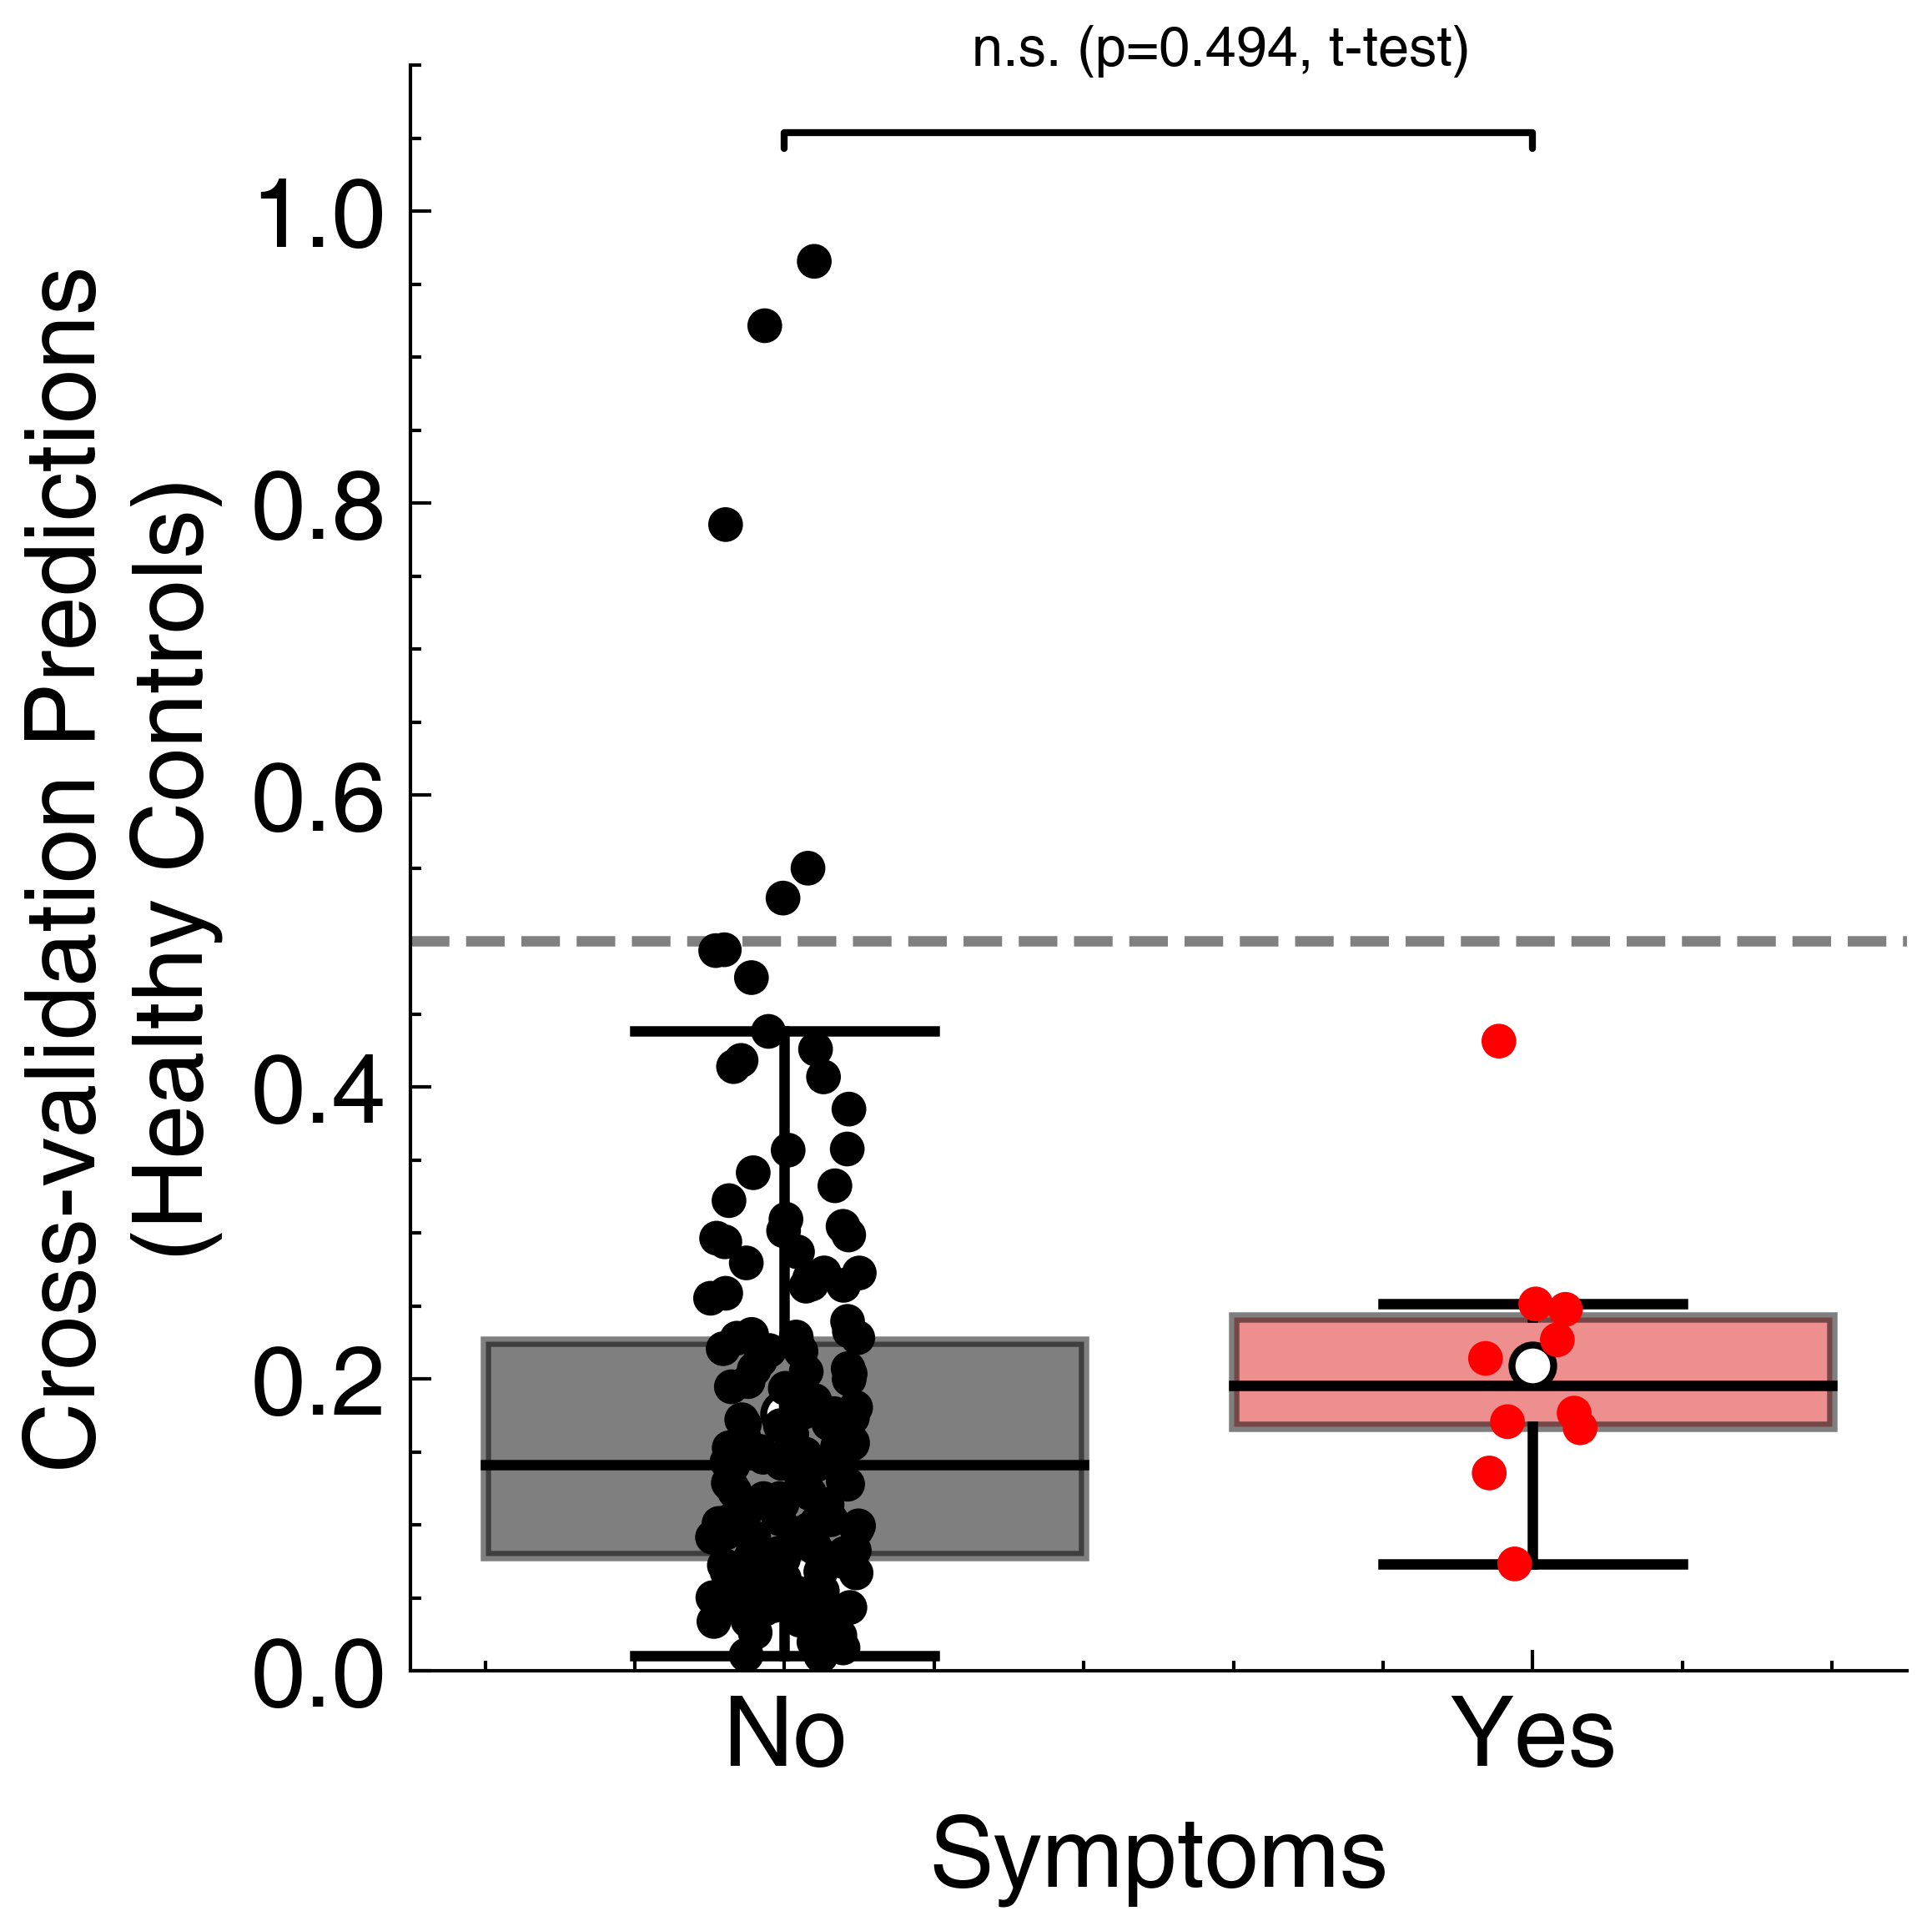

In [14]:
fig, ax = plt.subplots(1,1)
sns.boxplot(y='cv_pred', x='is_symp', data=ctrl_df,
           showmeans=True, meanprops={"marker": 'o', "markerfacecolor":"white", "markeredgecolor": "black"},
            showfliers=False, boxprops=dict(alpha=0.5), ax=ax)
sns.stripplot(y='cv_pred', x='is_symp', data=ctrl_df,
           dodge=True, edgecolor='black', ax=ax)
ax.set_xlabel('Symptoms')
ax.set_ylabel('Cross-validation Predictions\n(Healthy Controls)')
ax.annotate('', xy=(0,0.9), xytext=(1,0.9), arrowprops={'connectionstyle':'bar','arrowstyle':'-',\
                 'shrinkA':30,'shrinkB':30,'linewidth':1})
ax.annotate('n.s. (p=%.3f, t-test)' % tt.pvalue, xy=(0.25, 1.1), zorder=10)
ax.set_ylim(0,1.1)
ax.axhline(0.5, ls='--', color='grey')
fig.tight_layout()

In [15]:
print("FINISH:", datetime.now())

FINISH: 2022-03-23 12:09:14.905838
